# Решение Кулибабы Степана

In [73]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
import gc
import json
import warnings
import time
import sys
import os
import argparse
from pathlib import Path
from typing import Any, List, Dict, Tuple, Set, Union
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares


nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
class constants:
    # --- FILENAMES ---
    TRAIN_FILENAME = "train.csv"
    TARGETS_FILENAME = "targets.csv"
    CANDIDATES_FILENAME = "candidates.csv"
    USER_DATA_FILENAME = "users.csv"
    BOOK_DATA_FILENAME = "books.csv"
    BOOK_GENRES_FILENAME = "book_genres.csv"
    GENRES_FILENAME = "genres.csv"
    BOOK_DESCRIPTIONS_FILENAME = "book_descriptions.csv"
    SUBMISSION_FILENAME = "submission.csv"
    PROCESSED_DATA_FILENAME = "processed_features.parquet"
    MODEL_FILENAME = "lgb_model.txt"
    TFIDF_VECTORIZER_FILENAME = "tfidf_vectorizer.pkl"
    BERT_EMBEDDINGS_FILENAME = "bert_embeddings.pkl"

    # --- COLUMN NAMES ---
    COL_USER_ID = "user_id"
    COL_BOOK_ID = "book_id"
    COL_RATINGS = "rating"
    COL_SOURCE = "source"  # train или test
    COL_TIMESTAMP = "timestamp"
    COL_TARGET = "target"
    COL_PREDICTION = "prediction"
    COL_BOOK_ID_LIST = "book_id_list"

    # Metadata columns
    COL_TITLE = "title"
    COL_AUTHOR = "author"
    COL_PUBLISHER = "publisher"
    COL_PUBLICATION_YEAR = "publication_year"
    COL_IMAGE_URL = "image_url"
    COL_GENDER = "gender"
    COL_AGE = "age"
    COL_AGE_GROUP = "age_group"
    COL_HAS_READ = "has_read"
    COL_DESCRIPTION = "description"
    COL_GENRES = "genres"
    COL_AUTHOR_ID = "author_id"
    COL_LANGUAGE = "language"
    COL_AVG_RATING = "avg_rating"
    COL_RELEVANCE = "relevance"  # New target for multiclass: 0=cold, 1=planned, 2=read
    COL_GENRE_ID = "genre_id"

    # Feature columns
    F_USER_MEAN_RATING = "user_mean_rating"
    F_USER_RATINGS_COUNT = "user_ratings_count"
    F_BOOK_MEAN_RATING = "book_mean_rating"
    F_BOOK_RATINGS_COUNT = "book_ratings_count"
    F_AUTHOR_MEAN_RATING = "author_mean_rating"
    F_BOOK_GENRES_COUNT = "book_genres_count"
    F_USER_BOOK_INTERACTION = "f_user_book_interaction"

    # --- VALUES ---
    VAL_SOURCE_TRAIN = "train"
    VAL_SOURCE_TEST = "test"

    # --- MAGIC NUMBERS ---
    MAX_RANKING_LENGTH = 20
    MISSING_CAT_VALUE = "-1"
    MISSING_NUM_VALUE = -1

In [58]:
class config:
    # --- DIRECTORIES ---
    ROOT_DIR = Path(".")
    DATA_DIR = ROOT_DIR / "data"
    RAW_DATA_DIR = Path('/kaggle/input/nto-team/public')
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    MODEL_DIR = Path("output/models")
    SUBMISSION_DIR = Path("output/submissions")

    # Создаем папки, если их нет
    PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)

    # --- PARAMETERS ---
    RANDOM_STATE = 42
    TARGET = constants.COL_RELEVANCE

    # --- TEMPORAL SPLIT CONFIG ---
    TEMPORAL_SPLIT_RATIO = 0.9

    # --- TRAINING CONFIG ---
    EARLY_STOPPING_ROUNDS = 50

    # --- TF-IDF PARAMETERS ---
    TFIDF_MAX_FEATURES = 2000
    TFIDF_MIN_DF = 2
    TFIDF_MAX_DF = 0.95
    TFIDF_NGRAM_RANGE = (1, 2)

    # --- BERT PARAMETERS ---
    BERT_MODEL_NAME = "intfloat/multilingual-e5-large" 
    BERT_BATCH_SIZE = 16
    BERT_MAX_LENGTH = 512
    BERT_EMBEDDING_DIM = 1024
    BERT_DEVICE = "cuda" if torch and torch.cuda.is_available() else "cpu"

    # --- FEATURES ---
    CAT_FEATURES = [
        constants.COL_USER_ID,
        constants.COL_BOOK_ID,
        constants.COL_GENDER,
        constants.COL_AGE,
        constants.COL_AUTHOR_ID,
        constants.COL_PUBLICATION_YEAR,
        constants.COL_LANGUAGE,
        constants.COL_PUBLISHER,
    ]

    MODEL_FILENAME = 'model.json'

# Utils and FE functions

In [59]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(config.RANDOM_STATE)

def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type.name != "category" and "datetime" not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%")
    return df

In [60]:
def expand_candidates(candidates_df: pd.DataFrame) -> pd.DataFrame:
    print("Expanding candidates...")
    expanded_rows = []
    for _, row in candidates_df.iterrows():
        user_id = row[constants.COL_USER_ID]
        book_id_list_str = row[constants.COL_BOOK_ID_LIST]

        if pd.isna(book_id_list_str) or book_id_list_str == "":
            continue

        book_ids = [int(book_id.strip()) for book_id in book_id_list_str.split(",") if book_id.strip()]
        for book_id in book_ids:
            expanded_rows.append({constants.COL_USER_ID: user_id, constants.COL_BOOK_ID: book_id})

    expanded_df = pd.DataFrame(expanded_rows)
    expanded_df[constants.COL_USER_ID] = expanded_df[constants.COL_USER_ID].astype("int32")
    expanded_df[constants.COL_BOOK_ID] = expanded_df[constants.COL_BOOK_ID].astype("int32")
    print(f"Expanded candidates: {len(candidates_df):,} users -> {len(expanded_df):,} pairs")
    return expanded_df

In [ ]:
def mine_difficult_negatives(
    interactions: pd.DataFrame,
    top_k_hard: int = 12,
    n_random_fill: int = 3,
    latent_dim: int = 64,
    n_epochs: int = 15,
    l2_reg: float = 0.01
) -> pd.DataFrame:
    print("-" * 40)
    print("Initiating optimized ALS negative sampler...")

    user_cat = interactions[constants.COL_USER_ID].astype("category")
    item_cat = interactions[constants.COL_BOOK_ID].astype("category")

    user_codes = user_cat.cat.codes.values
    item_codes = item_cat.cat.codes.values
    
    unique_user_ids = user_cat.cat.categories
    unique_item_ids = item_cat.cat.categories
    
    n_users = len(unique_user_ids)
    n_items = len(unique_item_ids)

    csr_matrix = sp.csr_matrix(
        (np.ones(len(interactions), dtype=np.float32), (user_codes, item_codes)),
        shape=(n_users, n_items)
    )

    print(f"Fitting latent factors (Dim: {latent_dim})...")
    engine = AlternatingLeastSquares(
        factors=latent_dim,
        regularization=l2_reg,
        iterations=n_epochs,
        random_state=42
    )
    engine.fit(csr_matrix)

  
    print("Extracting dense negative candidates...")
    user_indices = np.arange(n_users)
    recs_ids, _ = engine.recommend(
        userid=user_indices,
        user_items=csr_matrix,
        N=top_k_hard,
        filter_already_liked_items=True
    )

    users_repeated_hard = np.repeat(user_indices, top_k_hard)
    items_flattened_hard = recs_ids.flatten()

    users_repeated_rnd = np.array([], dtype=int)
    items_flattened_rnd = np.array([], dtype=int)

    if n_random_fill > 0:
        print("Injecting stochastic noise...")
        users_repeated_rnd = np.repeat(user_indices, n_random_fill)
        items_flattened_rnd = np.random.randint(
            low=0, 
            high=n_items, 
            size=n_users * n_random_fill
        )

    print("Constructing final dataset...")
    final_user_indices = np.concatenate([users_repeated_hard, users_repeated_rnd])
    final_item_indices = np.concatenate([items_flattened_hard, items_flattened_rnd])

    result_df = pd.DataFrame({
        constants.COL_USER_ID: unique_user_ids[final_user_indices],
        constants.COL_BOOK_ID: unique_item_ids[final_item_indices]
    })

    print(f"Sampling complete. Total negatives: {len(result_df):,}")
    return result_df

def load_and_merge_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    print("Loading data...")

    dtype_spec = {
        constants.COL_USER_ID: "int32",
        constants.COL_BOOK_ID: "int32",
        constants.COL_HAS_READ: "int32",
        constants.COL_GENDER: "category",
        constants.COL_AGE: "float32",
        constants.COL_AUTHOR_ID: "int32",
        constants.COL_PUBLICATION_YEAR: "float32",
        constants.COL_LANGUAGE: "category",
        constants.COL_PUBLISHER: "category",
        constants.COL_AVG_RATING: "float32",
        constants.COL_GENRE_ID: "int16",
    }

    train_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.TRAIN_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_HAS_READ]},
        parse_dates=[constants.COL_TIMESTAMP],
    )
    all_book_ids = train_df[constants.COL_BOOK_ID].unique().tolist()
    neg_df = mine_difficult_negatives(
        train_df,
        top_k_hard=12,
        n_random_fill=3,
        latent_dim=64
    )
    neg_df['has_read'] = -1
    train_df = pd.concat([train_df, neg_df], ignore_index=True)
    print(f"Loaded train data: {len(train_df):,} rows")

    # Create relevance target
    train_df[constants.COL_RELEVANCE] = train_df[constants.COL_HAS_READ].map({1: 2, 0: 1, -1: 0}).astype("int8")
    print(f"Created relevance target: {train_df[constants.COL_RELEVANCE].value_counts().to_dict()}")

    targets_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.TARGETS_FILENAME,
        dtype={constants.COL_USER_ID: "int32"},
    )

    candidates_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.CANDIDATES_FILENAME,
        dtype={constants.COL_USER_ID: "int32"},
    )

    user_data_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.USER_DATA_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [constants.COL_USER_ID, constants.COL_GENDER, constants.COL_AGE]},
    )
    book_data_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.BOOK_DATA_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [constants.COL_BOOK_ID, constants.COL_AUTHOR_ID, constants.COL_PUBLICATION_YEAR, constants.COL_LANGUAGE, constants.COL_AVG_RATING, constants.COL_PUBLISHER]},
    )
    book_genres_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.BOOK_GENRES_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [constants.COL_BOOK_ID, constants.COL_GENRE_ID]},
    )
    book_descriptions_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.BOOK_DESCRIPTIONS_FILENAME,
        dtype={constants.COL_BOOK_ID: "int32"},
    )

    print("Data loaded. Merging datasets...")
    train_df[constants.COL_SOURCE] = constants.VAL_SOURCE_TRAIN
    train_df = train_df.merge(user_data_df, on=constants.COL_USER_ID, how="left")

    book_data_df = book_data_df.drop_duplicates(subset=[constants.COL_BOOK_ID])
    train_df = train_df.merge(book_data_df, on=constants.COL_BOOK_ID, how="left")

    print(f"Merged train data shape: {train_df.shape}")
    return train_df, targets_df, candidates_df, book_genres_df, book_descriptions_df


In [116]:
def add_genre_features(df: pd.DataFrame, book_genres_df: pd.DataFrame) -> pd.DataFrame:
    print("Adding genre features...")
    genre_counts = book_genres_df.groupby(constants.COL_BOOK_ID)[constants.COL_GENRE_ID].count().reset_index()
    genre_counts.columns = [constants.COL_BOOK_ID, constants.F_BOOK_GENRES_COUNT]
    return df.merge(genre_counts, on=constants.COL_BOOK_ID, how="left")

In [117]:
def add_text_features(df: pd.DataFrame, train_df: pd.DataFrame, descriptions_df: pd.DataFrame) -> pd.DataFrame:
    print("Adding text features (TF-IDF + SVD)...")
    vectorizer_path = config.MODEL_DIR / constants.TFIDF_VECTORIZER_FILENAME
    svd_path = config.MODEL_DIR / "tfidf_svd.pkl"
    
    all_descriptions = descriptions_df[[constants.COL_BOOK_ID, constants.COL_DESCRIPTION]].copy()
    all_descriptions[constants.COL_DESCRIPTION] = all_descriptions[constants.COL_DESCRIPTION].fillna("")
    description_map = dict(zip(all_descriptions[constants.COL_BOOK_ID], all_descriptions[constants.COL_DESCRIPTION]))
    
    text_data = df[constants.COL_BOOK_ID].map(description_map).fillna("")

    if vectorizer_path.exists() and svd_path.exists():
        print("Loading vectorizer and SVD...")
        vectorizer = joblib.load(vectorizer_path)
        svd = joblib.load(svd_path)
        tfidf_matrix = vectorizer.transform(text_data)
    else:
        print("Fitting TF-IDF and SVD...")
        train_books = train_df[constants.COL_BOOK_ID].unique()
        train_desc_text = descriptions_df[descriptions_df[constants.COL_BOOK_ID].isin(train_books)][constants.COL_DESCRIPTION].fillna("")
        
        vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=5,
            ngram_range=(1, 1),
            stop_words=list(russian_stopwords)
        )
        train_tfidf = vectorizer.fit_transform(train_desc_text)
        
        n_components = 32
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd.fit(train_tfidf)
        
        joblib.dump(vectorizer, vectorizer_path)
        joblib.dump(svd, svd_path)
        
        tfidf_matrix = vectorizer.transform(text_data)

    print("Transforming via SVD...")
    svd_matrix = svd.transform(tfidf_matrix)

    svd_cols = [f"desc_svd_{i}" for i in range(svd_matrix.shape[1])]
    svd_df = pd.DataFrame(svd_matrix, columns=svd_cols, index=df.index)
    
    del tfidf_matrix
    del text_data
    gc.collect()

    return pd.concat([df.reset_index(drop=True), svd_df.reset_index(drop=True)], axis=1)

In [118]:
def handle_missing_values(df: pd.DataFrame, train_df: pd.DataFrame) -> pd.DataFrame:
    print("Handling missing values...")

    global_mean = train_df[config.TARGET].mean()
    age_median = df[constants.COL_AGE].median()
    df[constants.COL_AGE] = df[constants.COL_AGE].fillna(age_median)

    fill_map = {
        constants.F_USER_MEAN_RATING: global_mean,
        constants.F_BOOK_MEAN_RATING: global_mean,
        constants.F_AUTHOR_MEAN_RATING: global_mean,
        constants.F_USER_RATINGS_COUNT: 0,
        constants.F_BOOK_RATINGS_COUNT: 0,
        constants.COL_AVG_RATING: global_mean,
        constants.F_BOOK_GENRES_COUNT: 0
    }

    for col, val in fill_map.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)

    # Fill TF-IDF/BERT with 0
    for col in df.columns:
        if col.startswith("tfidf_") or col.startswith("bert_"):
            df[col] = df[col].fillna(0.0)

    # Categories
    for col in config.CAT_FEATURES:
        if col in df.columns:
            if df[col].dtype.name in ("category", "object") and df[col].isna().any():
                df[col] = df[col].astype(str).fillna(constants.MISSING_CAT_VALUE).astype("category")
            elif pd.api.types.is_numeric_dtype(df[col].dtype) and df[col].isna().any():
                df[col] = df[col].fillna(constants.MISSING_NUM_VALUE)

    return df


In [119]:
def add_non_aggregate_features(
    df: pd.DataFrame,
    books_df: pd.DataFrame | None = None,
    users_df: pd.DataFrame | None = None,
    descriptions_df: pd.DataFrame | None = None,
    chunk_size: int = 2000,
) -> pd.DataFrame:
    print("[non_agg] Starting non-aggregate feature generation...")
    if books_df is not None:
        needed_book_cols = {"book_id", "title", "author_id", "publication_year", "language", "avg_rating", "publisher"}
        missing_cols = needed_book_cols - set(df.columns)
        if missing_cols:
            use_cols = list((needed_book_cols & set(books_df.columns)))
            df = df.merge(books_df[use_cols].drop_duplicates(subset=["book_id"]), on="book_id", how="left")

    if users_df is not None:
        needed_user_cols = {"user_id", "gender", "age"}
        missing_cols = needed_user_cols - set(df.columns)
        if missing_cols:
            use_cols = list((needed_user_cols & set(users_df.columns)))
            df = df.merge(users_df[use_cols].drop_duplicates(subset=["user_id"]), on="user_id", how="left")

    if descriptions_df is not None and constants.COL_DESCRIPTION not in df.columns:
        if constants.COL_BOOK_ID in descriptions_df.columns and constants.COL_DESCRIPTION in descriptions_df.columns:
            df = df.merge(
                descriptions_df[[constants.COL_BOOK_ID, constants.COL_DESCRIPTION]].drop_duplicates(subset=[constants.COL_BOOK_ID]),
                on=constants.COL_BOOK_ID,
                how="left",
            )

    if constants.COL_DESCRIPTION in df.columns:
        df[constants.COL_DESCRIPTION] = df[constants.COL_DESCRIPTION].fillna("").astype(str)
    else:
        df[constants.COL_DESCRIPTION] = ""

    if constants.COL_TITLE in df.columns:
        df[constants.COL_TITLE] = df[constants.COL_TITLE].fillna("").astype(str)
    else:
        df[constants.COL_TITLE] = ""

    df["desc_len_chars"] = df[constants.COL_DESCRIPTION].str.len().astype("int32")
    df["desc_len_words"] = df[constants.COL_DESCRIPTION].str.count(r"\S+").fillna(0).astype("int16")  # faster than .split()

    df["title_len_chars"] = df[constants.COL_TITLE].str.len().astype("int16")
    df["title_len_words"] = df[constants.COL_TITLE].str.count(r"\S+").fillna(0).astype("int8")
    df["title_long"] = (df["title_len_words"] > 3).astype("int8")

    current_year = pd.Timestamp.now().year
    pub_year_col = constants.COL_PUBLICATION_YEAR
    if pub_year_col in df.columns:
        df["publication_year_filled"] = pd.to_numeric(df[pub_year_col], errors="coerce").fillna(current_year).astype("int32")
    else:
        df["publication_year_filled"] = current_year

    df["book_age"] = (current_year - df["publication_year_filled"]).clip(lower=0).astype("int16")
    df["is_old_book"] = (df["book_age"] > 20).astype("int8")
    df["is_recent_book"] = (df["book_age"] < 5).astype("int8")

    lang_col = constants.COL_LANGUAGE
    if lang_col in df.columns:
        df["language_missing"] = df[lang_col].isna().astype("int8")
        if pd.api.types.is_categorical_dtype(df[lang_col]):
            df["language_code_cat"] = df[lang_col].cat.codes.astype("int32")
        else:
            df["language_code_cat"] = pd.to_numeric(df[lang_col], errors="coerce").fillna(-1).astype("int32")
    else:
        df["language_missing"] = 1
        df["language_code_cat"] = -1

    pub_col = constants.COL_PUBLISHER
    if pub_col in df.columns:
        if pd.api.types.is_categorical_dtype(df[pub_col]):
            df["publisher_id_filled"] = df[pub_col].cat.codes.astype("int32")
        else:
            df["publisher_id_filled"] = pd.to_numeric(df[pub_col], errors="coerce").fillna(-1).astype("int32")
    else:
        df["publisher_id_filled"] = -1

    age_col = constants.COL_AGE
    if age_col in df.columns:
        df["age_missing"] = df[age_col].isna().astype("int8")
        df["age_filled"] = pd.to_numeric(df[age_col], errors="coerce").fillna(0).astype("int16")
    else:
        df["age_missing"] = 1
        df["age_filled"] = 0
    df["age_group_decade"] = (df["age_filled"] // 10).clip(0, 10).astype("int8")
    df["age_squared"] = (df["age_filled"].astype("float32") ** 2).astype("float32")

    df["desc_unique_char_ratio"] = df[constants.COL_DESCRIPTION].map(
        lambda t: (len(set(t)) / (len(t) + 1)) if isinstance(t, str) and len(t) > 0 else 0.0
    ).astype("float32")
    df["desc_has_exclamation"] = df[constants.COL_DESCRIPTION].str.contains("!", regex=False, na=False).astype("int8")
    df["desc_has_question"] = df[constants.COL_DESCRIPTION].str.contains("?", regex=False, na=False).astype("int8")
    df["desc_num_commas"] = df[constants.COL_DESCRIPTION].str.count(",").fillna(0).astype("int16")
    df["title_has_colon"] = df[constants.COL_TITLE].str.contains(":", regex=False, na=False).astype("int8")

    print("[non_agg] Computing unique word stats (chunked)...")
    df["desc_unique_words"] = 0
    df["desc_avg_word_len"] = 0.0
    n = len(df)

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        block = df.iloc[start:end]
        uniqs = block[constants.COL_DESCRIPTION].map(
            lambda s: len(set(s.split())) if s else 0
        ).astype("int16")
        avgw = block[constants.COL_DESCRIPTION].map(
            lambda s: (np.mean([len(w) for w in s.split()]) if s and len(s.split())>0 else 0.0)
        ).astype("float32")

        df.iloc[start:end, df.columns.get_loc("desc_unique_words")] = uniqs.values
        df.iloc[start:end, df.columns.get_loc("desc_avg_word_len")] = avgw.values

        # free memory in loop
        del uniqs, avgw
        gc.collect()

    print("[non_agg] Computing title-description word overlap (chunked)...")

    df["title_desc_common_words"] = 0
    df["title_desc_common_ratio_to_title"] = 0.0
    df["title_desc_common_ratio_to_desc"] = 0.0

    def _common_count_vec(titles, descs):
        # titles, descs are pandas Series (chunk); return arrays
        out_common = np.zeros(len(titles), dtype="int16")
        out_ratio_t = np.zeros(len(titles), dtype="float32")
        out_ratio_d = np.zeros(len(titles), dtype="float32")
        for i, (t, d) in enumerate(zip(titles, descs)):
            if not t or not d:
                continue
            tset = set(w.lower() for w in t.split())
            dset = set(w.lower() for w in d.split())
            common = len(tset & dset)
            out_common[i] = common
            out_ratio_t[i] = common / (len(tset) if len(tset) > 0 else 1)
            out_ratio_d[i] = common / (len(dset) if len(dset) > 0 else 1)
        return out_common, out_ratio_t, out_ratio_d

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        titles = df.iloc[start:end][constants.COL_TITLE].values
        descs = df.iloc[start:end][constants.COL_DESCRIPTION].values
        c_common, c_rt, c_rd = _common_count_vec(titles, descs)
        df.iloc[start:end, df.columns.get_loc("title_desc_common_words")] = c_common
        df.iloc[start:end, df.columns.get_loc("title_desc_common_ratio_to_title")] = c_rt
        df.iloc[start:end, df.columns.get_loc("title_desc_common_ratio_to_desc")] = c_rd
        del c_common, c_rt, c_rd
        gc.collect()

    cos_col = "desc_title_tfidf_cosine"
    df[cos_col] = 0.0
    try:
        vectorizer_path = config.MODEL_DIR / constants.TFIDF_VECTORIZER_FILENAME
        if vectorizer_path.exists():
            vectorizer = joblib.load(vectorizer_path)

            # chunked transform to avoid building full dense/sparse matrices for all rows
            for start in range(0, n, chunk_size):
                end = min(start + chunk_size, n)
                desc_texts = df.iloc[start:end][constants.COL_DESCRIPTION].astype(str).tolist()
                title_texts = df.iloc[start:end][constants.COL_TITLE].astype(str).tolist()

                desc_vec = vectorizer.transform(desc_texts)   # sparse
                title_vec = vectorizer.transform(title_texts) # sparse

                # numerator: sum of elementwise product per row
                numer = np.asarray(desc_vec.multiply(title_vec).sum(axis=1)).reshape(-1)
                desc_sq = np.asarray(desc_vec.multiply(desc_vec).sum(axis=1)).reshape(-1)
                title_sq = np.asarray(title_vec.multiply(title_vec).sum(axis=1)).reshape(-1)
                denom = np.sqrt(desc_sq) * np.sqrt(title_sq)
                cos_vals = np.zeros_like(numer, dtype="float32")
                nonzero = denom > 0
                if nonzero.any():
                    cos_vals[nonzero] = (numer[nonzero] / denom[nonzero]).astype("float32")
                df.iloc[start:end, df.columns.get_loc(cos_col)] = cos_vals

                del desc_vec, title_vec, numer, desc_sq, title_sq, denom, cos_vals
                gc.collect()
        else:
            # no vectorizer -> keep zeros
            pass
    except Exception as e:
        print("Warning: TF-IDF cosine failed (memory-safe path). Error:", e)
        df[cos_col] = 0.0

    int8_cols = [
        "title_long", "is_old_book", "is_recent_book", "language_missing", "age_missing",
        "desc_has_exclamation", "desc_has_question", "title_has_colon"
    ]
    for c in int8_cols:
        if c in df.columns:
            df[c] = df[c].astype("int8")

    for c in ["desc_len_chars", "desc_len_words", "desc_unique_words", "title_len_chars", "title_len_words",
              "title_desc_common_words", "publication_year_filled", "book_age", "publisher_id_filled",
              "language_code_cat", "age_filled"]:
        if c in df.columns:
            # safe downcast where possible
            try:
                df[c] = pd.to_numeric(df[c], errors="coerce").fillna(-1).astype("int32")
            except Exception:
                pass

    # float columns
    for c in ["desc_avg_word_len", "title_desc_common_ratio_to_title", "title_desc_common_ratio_to_desc",
              "desc_unique_char_ratio", "age_squared", cos_col]:
        if c in df.columns:
            df[c] = df[c].astype("float32")

    # drop helper col if desired
    if "publication_year_filled" in df.columns:
        df.drop(columns=["publication_year_filled"], inplace=True)

    print("[non_agg] Finish")
    return df


In [120]:
def add_bert_features(df: pd.DataFrame, _train_df: pd.DataFrame, descriptions_df: pd.DataFrame) -> pd.DataFrame:
    cfg = globals().get('config', config)
    print(f"Adding text features ({cfg.BERT_MODEL_NAME} embeddings)...")

    embeddings_path = cfg.MODEL_DIR / f"{cfg.BERT_MODEL_NAME.split('/')[-1]}_embeddings.pkl"

    # Проверяем кэш
    if embeddings_path.exists():
        print(f"Loading cached embeddings from {embeddings_path}")
        embeddings_dict = joblib.load(embeddings_path)
    else:
        if 'torch' not in sys.modules or not torch:
            print("Torch not available, skipping Embeddings.")
            return df 

        print(f"Computing embeddings via {cfg.BERT_MODEL_NAME} model...")
        
        tokenizer = AutoTokenizer.from_pretrained(cfg.BERT_MODEL_NAME)
        model = AutoModel.from_pretrained(cfg.BERT_MODEL_NAME)
        model.to(cfg.BERT_DEVICE)
        model.eval()

        all_descriptions = descriptions_df[[constants.COL_BOOK_ID, constants.COL_DESCRIPTION]].copy()
        all_descriptions[constants.COL_DESCRIPTION] = all_descriptions[constants.COL_DESCRIPTION].fillna("")
        
        # E5 требует префикса "passage: " для документов!
        all_descriptions['text_input'] = "passage: " + all_descriptions[constants.COL_DESCRIPTION]
        
        unique_books = all_descriptions.drop_duplicates(subset=[constants.COL_BOOK_ID])
        
        book_ids = unique_books[constants.COL_BOOK_ID].to_numpy()
        texts = unique_books['text_input'].to_numpy().tolist()

        embeddings_dict = {}
        num_batches = (len(texts) + cfg.BERT_BATCH_SIZE - 1) // cfg.BERT_BATCH_SIZE

        # Функция для Mean Pooling
        def average_pool(last_hidden_states, attention_mask):
            last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
            return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

        with torch.no_grad():
            for batch_idx in tqdm(range(num_batches), desc="Embedding Batches"):
                start = batch_idx * cfg.BERT_BATCH_SIZE
                end = min(start + cfg.BERT_BATCH_SIZE, len(texts))
                
                # Токенизация
                encoded = tokenizer(
                    texts[start:end],
                    padding=True,
                    truncation=True,
                    max_length=cfg.BERT_MAX_LENGTH,
                    return_tensors="pt"
                ).to(cfg.BERT_DEVICE)

                outputs = model(**encoded)
                
                embeddings = average_pool(outputs.last_hidden_state, encoded['attention_mask'])
                embeddings = F.normalize(embeddings, p=2, dim=1)
                embeddings_np = embeddings.cpu().numpy()

                for bid, emb in zip(book_ids[start:end], embeddings_np):
                    embeddings_dict[bid] = emb

        # Сохраняем кэш
        print(f"Saving embeddings to {embeddings_path}")
        joblib.dump(embeddings_dict, embeddings_path)

    print("Mapping embeddings to Dataframe...")
    emb_dim = len(next(iter(embeddings_dict.values()))) if embeddings_dict else cfg.BERT_EMBEDDING_DIM
    zero_emb = np.zeros(emb_dim, dtype=np.float32)
    mapped_embs = df[constants.COL_BOOK_ID].map(embeddings_dict)
    final_embs = np.vstack([x if isinstance(x, np.ndarray) else zero_emb for x in mapped_embs.values])

    bert_df = pd.DataFrame(
        final_embs,
        columns=[f"bert_{i}" for i in range(emb_dim)], # Переименовал в 'e5_' для ясности
        index=df.index
    )
    
    del mapped_embs
    import gc
    gc.collect()

    return pd.concat([df.reset_index(drop=True), bert_df.reset_index(drop=True)], axis=1)

In [121]:
def create_features(
    df: pd.DataFrame,
    book_genres_df: pd.DataFrame,
    descriptions_df: pd.DataFrame,
    include_aggregates: bool = False,
    include_bert: bool = True,
) -> pd.DataFrame:
    print("Starting feature engineering pipeline...")
    train_df = df[df[constants.COL_SOURCE] == constants.VAL_SOURCE_TRAIN].copy()


    df = add_non_aggregate_features(df, books_df=None, users_df=None, descriptions_df=descriptions_df)

    if include_aggregates:
        df = add_aggregate_features(df, train_df)

    df = add_genre_features(df, book_genres_df)
    df = add_text_features(df, train_df, descriptions_df)

    if include_bert:
        df = add_bert_features(df, train_df, descriptions_df)

    df = handle_missing_values(df, train_df)

    for col in config.CAT_FEATURES:
        if col in df.columns:
            df[col] = df[col].astype("category")

    print("Feature engineering complete.")
    return df

In [122]:
def temporal_split_by_date(
    df: pd.DataFrame, split_date: pd.Timestamp, timestamp_col: str = constants.COL_TIMESTAMP
) -> Tuple[pd.Series, pd.Series]:
    if timestamp_col not in df.columns:
        raise ValueError(f"Timestamp column {timestamp_col} missing")

    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    train_mask = df[timestamp_col] <= split_date
    val_mask = df[timestamp_col] > split_date

    if train_mask.sum() == 0 or val_mask.sum() == 0:
        raise ValueError("Split resulted in empty train or validation set")

    return train_mask, val_mask

def get_split_date_from_ratio(
    df: pd.DataFrame, ratio: float, timestamp_col: str = constants.COL_TIMESTAMP
) -> pd.Timestamp:
    if not 0 < ratio < 1:
        raise ValueError("Ratio must be between 0 and 1")

    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    sorted_timestamps = df[timestamp_col].sort_values()
    threshold_index = int(len(sorted_timestamps) * ratio)
    return sorted_timestamps.iloc[threshold_index]


In [123]:
def dcg_at_k(relevance_scores: list[int], k: int) -> float:
    scores_array = np.asarray(relevance_scores, dtype=float)[:k]
    if scores_array.size:
        return float(np.sum(scores_array / np.log2(np.arange(2, scores_array.size + 2))))
    return 0.0

def ndcg_at_k(relevance_scores: list[int], k: int) -> float:
    if len(relevance_scores) == 0:
        return 0.0

    top_k_scores = relevance_scores[:k]
    if sum(top_k_scores) == 0:
        return 0.0

    calculated_dcg = dcg_at_k(top_k_scores, k=k)
    ideal_scores = sorted(top_k_scores, reverse=True)
    ideal_dcg = dcg_at_k(ideal_scores, k=k)

    return calculated_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def calculate_stage2_metrics(submission: pd.DataFrame, solution: pd.DataFrame) -> dict[str, float]:
    K = 20

    def parse_book_id_list(book_list_str: str | float) -> set[int]:
        if pd.isna(book_list_str) or book_list_str == "":
            return set()
        return {int(x.strip()) for x in str(book_list_str).split(",") if x.strip()}

    solution_grouped = solution.groupby("user_id").agg({
        "book_id_list_read": lambda x: parse_book_id_list(x.iloc[0]) if len(x) > 0 else set(),
        "book_id_list_planned": lambda x: parse_book_id_list(x.iloc[0]) if len(x) > 0 else set(),
    })

    merged_df = submission.merge(solution_grouped, on="user_id", how="inner")

    if merged_df.empty:
        return {"Score": 0.0, "NDCG@20": 0.0}

    merged_df["book_id_list_read"] = merged_df["book_id_list_read"].apply(
        lambda x: x if isinstance(x, set) else set()
    )
    merged_df["book_id_list_planned"] = merged_df["book_id_list_planned"].apply(
        lambda x: x if isinstance(x, set) else set()
    )

    def parse_prediction_list(book_list_str: str | float) -> list[int]:
        if pd.isna(book_list_str) or book_list_str == "":
            return []
        return [int(x.strip()) for x in str(book_list_str).split(",") if x.strip()]

    merged_df["y_pred"] = merged_df["book_id_list"].apply(parse_prediction_list)

    def calculate_relevance_scores(row: pd.Series) -> list[int]:
        y_pred = row["y_pred"]
        books_read = row["book_id_list_read"]
        books_planned = row["book_id_list_planned"]
        relevance = []
        for book_id in y_pred:
            if book_id in books_read:
                relevance.append(2)
            elif book_id in books_planned:
                relevance.append(1)
            else:
                relevance.append(0)
        return relevance

    merged_df["relevance_scores"] = merged_df.apply(calculate_relevance_scores, axis=1)
    merged_df[f"ndcg@{K}"] = merged_df["relevance_scores"].apply(
        lambda scores: ndcg_at_k(scores, k=K)
    )

    mean_ndcg = merged_df[f"ndcg@{K}"].mean()
    return {"Score": mean_ndcg, f"NDCG@{K}": mean_ndcg}

def split_by_user_id(df, user_col, test_size=0.2, seed=42):
    unique_users = df[user_col].unique()

    train_users, val_users = train_test_split(
        unique_users, test_size=test_size, random_state=seed, shuffle=True
    )

    train_mask = df[user_col].isin(train_users)
    val_mask = df[user_col].isin(val_users)

    return train_mask, val_mask

# PREPARE DATA EXECUTION

In [131]:
print("=" * 60)
print("Data Preparation Pipeline")
print("=" * 60)

merged_df, targets_df, candidates_df, book_genres_df, descriptions_df = load_and_merge_data()
featured_df = create_features(
    merged_df,
    book_genres_df,
    descriptions_df,
    include_aggregates=False,
    include_bert=True
)

processed_path = config.PROCESSED_DATA_DIR / constants.PROCESSED_DATA_FILENAME
print(f"Saving processed data to {processed_path}...")
featured_df.to_parquet(processed_path, index=False, engine="pyarrow", compression="snappy")
print("Data preparation complete!")

Data Preparation Pipeline
Loading data...
----------------------------------------
Initiating optimized ALS negative sampler...
Fitting latent factors (Dim: 64)...


  0%|          | 0/15 [00:00<?, ?it/s]

Extracting dense negative candidates...
Injecting stochastic noise...
Constructing final dataset...
Sampling complete. Total negatives: 94,757
Loaded train data: 363,818 rows
Created relevance target: {2: 156603, 1: 112458, 0: 94757}
Data loaded. Merging datasets...
Merged train data shape: (363818, 16)
Starting feature engineering pipeline...
[non_agg] Starting non-aggregate feature generation...
[non_agg] Computing unique word stats (chunked)...
[non_agg] Computing title-description word overlap (chunked)...
[non_agg] Finish
Adding genre features...
Adding text features (TF-IDF + SVD)...
Loading vectorizer and SVD...
Transforming via SVD...
Adding text features (intfloat/multilingual-e5-large embeddings)...
Loading cached embeddings from output/models/multilingual-e5-large_embeddings.pkl
Mapping embeddings to Dataframe...
Handling missing values...
Feature engineering complete.
Saving processed data to data/processed/processed_features.parquet...
Data preparation complete!


In [134]:
# --- LOAD & SPLIT DATA ---
print("Loading prepared data...")
featured_df = pd.read_parquet(config.PROCESSED_DATA_DIR / constants.PROCESSED_DATA_FILENAME, engine="pyarrow")


featured_df = reduce_mem_usage(featured_df)
train_set = featured_df[featured_df[constants.COL_SOURCE] == constants.VAL_SOURCE_TRAIN].copy()

if not pd.api.types.is_datetime64_any_dtype(train_set[constants.COL_TIMESTAMP]):
    train_set[constants.COL_TIMESTAMP] = pd.to_datetime(train_set[constants.COL_TIMESTAMP])

print(f"Performing temporal split with ratio {config.TEMPORAL_SPLIT_RATIO}...")
split_date = get_split_date_from_ratio(train_set, config.TEMPORAL_SPLIT_RATIO, constants.COL_TIMESTAMP)
print(f"Split date: {split_date}")

val_c = train_set['user_id'].value_counts()
good_users = val_c[val_c>=1].index
train_set = train_set[train_set['user_id'].isin(good_users)]
train_mask, val_mask = split_by_user_id(train_set, user_col=constants.COL_USER_ID, test_size=0.2, seed=42)
train_split = train_set[train_mask].copy()
val_split = train_set[val_mask].copy()

print(f"Train: {len(train_split):,}, Val: {len(val_split):,}")

Loading prepared data...
Memory usage of dataframe is 1568.43 MB
Memory usage after optimization is: 1509.10 MB
Decreased by 3.8%
Performing temporal split with ratio 0.9...
Split date: NaT
Train: 290,897, Val: 72,921


In [135]:
# --- PREPARE FEATURES & OPTIMIZE ---
exclude_cols = [constants.COL_SOURCE, config.TARGET, constants.COL_PREDICTION, constants.COL_TIMESTAMP]
features = [col for col in train_split.columns if col not in exclude_cols]
non_feature_object_cols = train_split[features].select_dtypes(include=["object"]).columns.tolist()
features = [f for f in features if f not in non_feature_object_cols]

train_split = train_split.sort_values('user_id').reset_index(drop=True)
val_split = val_split.sort_values('user_id').reset_index(drop=True)

X_train = train_split[features].copy()
y_train = train_split[config.TARGET]
X_val = val_split[features].copy()
y_val = val_split[config.TARGET]

# Optimization
float64_cols = X_train.select_dtypes(include=["float64"]).columns
if len(float64_cols) > 0:
    X_train[float64_cols] = X_train[float64_cols].astype("float32")
    X_val[float64_cols] = X_val[float64_cols].astype("float32")

categorical_features = [f for f in features if train_split[f].dtype.name == "category"]
categorical_indices = [features.index(f) for f in categorical_features if f in features]

In [136]:
train_pool = Pool(
    data=X_train.drop(columns=['has_read', 'rating', 'avg_rating', 'user_id']),
    label=y_train,
    group_id=X_train['user_id'],
    cat_features=categorical_features
)

val_pool = Pool(
    data=X_val.drop(columns=['has_read', 'rating',  'avg_rating', 'user_id']),
    label=y_val,
    group_id=X_val['user_id'],
    cat_features=categorical_features
)

params = {
    "loss_function": "YetiRank",
    "eval_metric": "NDCG:top=10",
    "random_seed": 42,
    "verbose": 100,
    "early_stopping_rounds": 400,
    "task_type": 'GPU',

    "iterations": 5000,
    "learning_rate": 0.07,
    "bagging_temperature": 0.5,
    "l2_leaf_reg": 3.5,
    "depth": 10,
}
model = CatBoostRanker(**params).fit(train_pool, eval_set=[val_pool])

Groupwise loss function. OneHotMaxSize set to 10


Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7295519	best: 0.7295519 (0)	total: 65.1ms	remaining: 5m 25s
100:	test: 0.7945872	best: 0.7945872 (100)	total: 6.26s	remaining: 5m 3s
200:	test: 0.8085919	best: 0.8085919 (200)	total: 12.4s	remaining: 4m 55s
300:	test: 0.8151707	best: 0.8151707 (300)	total: 18.5s	remaining: 4m 48s
400:	test: 0.8180683	best: 0.8183588 (363)	total: 24.6s	remaining: 4m 42s
500:	test: 0.8200560	best: 0.8204518 (498)	total: 30.7s	remaining: 4m 35s
600:	test: 0.8216514	best: 0.8216514 (600)	total: 36.8s	remaining: 4m 29s
700:	test: 0.8221767	best: 0.8226396 (660)	total: 42.9s	remaining: 4m 22s
800:	test: 0.8228372	best: 0.8235405 (757)	total: 49s	remaining: 4m 16s
900:	test: 0.8232164	best: 0.8236447 (898)	total: 55.1s	remaining: 4m 10s
1000:	test: 0.8241566	best: 0.8241566 (1000)	total: 1m 1s	remaining: 4m 4s
1100:	test: 0.8248515	best: 0.8251735 (1089)	total: 1m 7s	remaining: 3m 58s
1200:	test: 0.8253654	best: 0.8260265 (1175)	total: 1m 13s	remaining: 3m 52s
1300:	test: 0.8257839	best: 0.8260265 

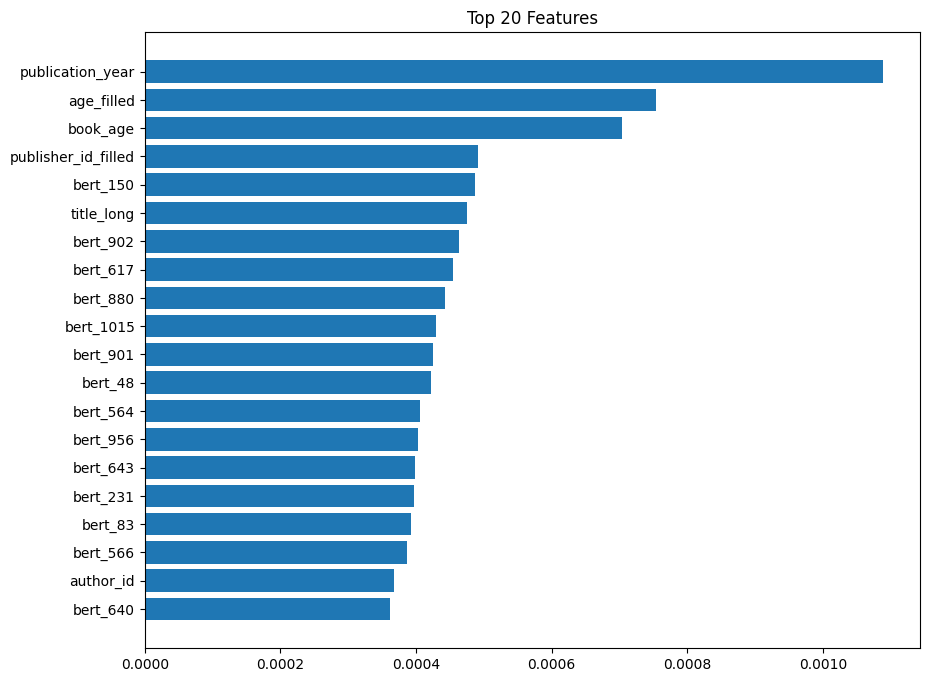

In [137]:
feat_imp = pd.DataFrame({
    "feature": model.feature_names_,
    "importance": model.get_feature_importance(val_pool, type="FeatureImportance")
}).sort_values("importance", ascending=False)
top_n = 20
top_feat = feat_imp.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_feat["feature"], top_feat["importance"])
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Features")
plt.show()

In [138]:
model.save_model(str(config.MODEL_DIR / config.MODEL_FILENAME), format='json')
features_path = config.MODEL_DIR / "features_list.json"
with open(features_path, "w") as f:
    json.dump(model.feature_names_, f)
print(f"Feature list saved to {features_path}")

Feature list saved to output/models/features_list.json


# Predict

In [139]:
# --- LOAD PREDICTION DATA ---
print("Loading candidates and metadata...")
targets_df = pd.read_csv(config.RAW_DATA_DIR / constants.TARGETS_FILENAME, dtype={constants.COL_USER_ID: "int32"})
candidates_df = pd.read_csv(config.RAW_DATA_DIR / constants.CANDIDATES_FILENAME, dtype={constants.COL_USER_ID: "int32"})

print("Expanding candidates...")
candidates_pairs_df = expand_candidates(candidates_df)

print("Loading processed data for base features...")
featured_df = pd.read_parquet(config.PROCESSED_DATA_DIR / constants.PROCESSED_DATA_FILENAME, engine="pyarrow")
featured_df = reduce_mem_usage(featured_df)
train_df = featured_df[featured_df[constants.COL_SOURCE] == constants.VAL_SOURCE_TRAIN].copy()

# Merging Meta
print("Merging metadata...")
_, _, _, book_genres_df, descriptions_df = load_and_merge_data()
user_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.USER_DATA_FILENAME)
book_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_DATA_FILENAME).drop_duplicates(subset=[constants.COL_BOOK_ID])

candidates_with_meta = candidates_pairs_df.merge(user_data_df, on=constants.COL_USER_ID, how="left")
candidates_with_meta = candidates_with_meta.merge(book_data_df, on=constants.COL_BOOK_ID, how="left")

Loading candidates and metadata...
Expanding candidates...
Expanding candidates...
Expanded candidates: 3,512 users -> 81,048 pairs
Loading processed data for base features...
Memory usage of dataframe is 1568.43 MB
Memory usage after optimization is: 1509.10 MB
Decreased by 3.8%
Merging metadata...
Loading data...
----------------------------------------
Initiating optimized ALS negative sampler...
Fitting latent factors (Dim: 64)...


  0%|          | 0/15 [00:00<?, ?it/s]

Extracting dense negative candidates...
Injecting stochastic noise...
Constructing final dataset...
Sampling complete. Total negatives: 94,757
Loaded train data: 363,818 rows
Created relevance target: {2: 156603, 1: 112458, 0: 94757}
Data loaded. Merging datasets...
Merged train data shape: (363818, 16)


In [140]:
# --- PREPARE CANDIDATE FEATURES ---
book_features = featured_df[[constants.COL_BOOK_ID]].drop_duplicates()
feature_cols = [
    col for col in featured_df.columns
    if col not in [constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_SOURCE, constants.COL_TIMESTAMP, constants.COL_HAS_READ, constants.COL_TARGET, constants.COL_PREDICTION] + config.CAT_FEATURES
    and not col.startswith("tfidf_") and not col.startswith("bert_")
]
text_feature_cols = [col for col in featured_df.columns if col.startswith("tfidf_") or col.startswith("bert_")]
cols_to_extract = [constants.COL_BOOK_ID]

book_features_df = featured_df[cols_to_extract].drop_duplicates(subset=[constants.COL_BOOK_ID])

cols_to_drop = [c for c in book_features_df.columns if c in candidates_with_meta.columns and c != constants.COL_BOOK_ID]
candidates_with_meta = candidates_with_meta.drop(columns=cols_to_drop)
candidates_with_meta = candidates_with_meta.merge(book_features_df, on=constants.COL_BOOK_ID, how="left")

candidates_final = candidates_with_meta.copy()
candidates_final = add_non_aggregate_features(candidates_final, books_df=None, users_df=None, descriptions_df=descriptions_df)
candidates_final = add_genre_features(candidates_final, book_genres_df)
candidates_final = add_text_features(candidates_final, train_df, descriptions_df)
candidates_final = add_bert_features(candidates_final, train_df, descriptions_df)

# Load feature list
with open(config.MODEL_DIR / "features_list.json", "r") as f:
    features = json.load(f)

# Ensure all columns exist
for feat in features:
    if feat not in candidates_final.columns:
        print(feat)
        candidates_final[feat] = 0

# Match categories
for col in features:
    if col in featured_df.columns and featured_df[col].dtype.name == "category":
        train_cats = featured_df[col].cat.categories
        candidates_final[col] = candidates_final[col].astype(str)
        # Fill unknown categories
        valid_mask = candidates_final[col].isin([str(c) for c in train_cats])
        if not valid_mask.all():
            candidates_final.loc[~valid_mask, col] = str(train_cats[0])
        candidates_final[col] = pd.Categorical(candidates_final[col], categories=train_cats, ordered=False)

candidates_final = candidates_final.sort_values('user_id').reset_index(drop=True)
X_test = candidates_final[features]

[non_agg] Starting non-aggregate feature generation...
[non_agg] Computing unique word stats (chunked)...
[non_agg] Computing title-description word overlap (chunked)...
[non_agg] Finish
Adding genre features...
Adding text features (TF-IDF + SVD)...
Loading vectorizer and SVD...
Transforming via SVD...
Adding text features (intfloat/multilingual-e5-large embeddings)...
Loading cached embeddings from output/models/multilingual-e5-large_embeddings.pkl
Mapping embeddings to Dataframe...


In [141]:
test_pool = Pool(
    X_test[X_train.drop(columns=['has_read', 'rating', 'avg_rating', 'user_id']).columns.tolist()],
    group_id=candidates_final['user_id'],
    cat_features=categorical_features
)

In [142]:
print("Predicting...")
model = CatBoostRanker()
model.load_model(str(config.MODEL_DIR / config.MODEL_FILENAME), format='json')
candidates_final["prediction"] = model.predict(test_pool)

print("Ranking and generating submission (Vectorized)...")
candidates_final.sort_values(
    by=[constants.COL_USER_ID, "prediction"], 
    ascending=[True, False], 
    inplace=True
)

top_candidates = candidates_final.groupby(constants.COL_USER_ID).head(constants.MAX_RANKING_LENGTH)
grouped_preds = top_candidates.groupby(constants.COL_USER_ID)[constants.COL_BOOK_ID].apply(
    lambda x: ",".join(x.astype(str))
).reset_index()

grouped_preds.rename(columns={constants.COL_BOOK_ID: constants.COL_BOOK_ID_LIST}, inplace=True)

submission_df = pd.DataFrame({constants.COL_USER_ID: targets_df[constants.COL_USER_ID].unique()})
submission_df = submission_df.merge(grouped_preds, on=constants.COL_USER_ID, how='left')
submission_df[constants.COL_BOOK_ID_LIST] = submission_df[constants.COL_BOOK_ID_LIST].fillna("")

submission_path = config.SUBMISSION_DIR / constants.SUBMISSION_FILENAME
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")

Predicting...
Ranking and generating submission (Vectorized)...
Submission saved to output/submissions/submission.csv


In [144]:
submission_df.head()

,user_id,book_id_list
0,210,"3015694,3988468,2447113,2225251,1673950,128103..."
1,1380,"1326209,482934,2290484,2379664,2548861,1098150..."
2,2050,"317849,822326,2254200,2053462,1021078,460492,2..."
3,2740,"1553798,112023,2107128,1737221,1339705,181062,..."
4,4621,"28642,28639,28901,31479,2191492,28638,3015694,..."
